# 📊 LDA Visualization: Linear Discriminant Analysis of Reasoning Subspace

This notebook applies Linear Discriminant Analysis (LDA) to visualize the separation between correct and incorrect reasoning in the Phase A data.

**LDA** is a supervised dimensionality reduction technique that finds directions maximizing class separability, making it ideal for visualizing how well neural network activations distinguish between correct and incorrect reasoning.

**Data Source:** `vm_results/Qwen2.5-7B-Instruct__qwen_causality_v3/mmlu_pro/`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
from pathlib import Path
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 10),
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})
COLORS = {'primary': '#2E86AB', 'secondary': '#A23B72', 'accent': '#F18F01', 'correct': '#2D936C', 'incorrect': '#D64045'}

DATA_DIR = Path('../../vm_results/Qwen2.5-7B-Instruct__qwen_causality_v3/mmlu_pro')
OUTPUT_DIR = Path('../outputs/lda_analysis')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Data exists: {DATA_DIR.exists()}')

Data exists: True


In [2]:
# Load all data
metrics_df = pd.read_csv(DATA_DIR / 'screening' / 'metrics_flat.csv').sort_values('layer_idx')
pooled = np.load(DATA_DIR / 'pooled.npz')
X, layers = pooled['X'], pooled['layers']
labels = np.load(DATA_DIR / 'labels.npy')
directions = np.load(DATA_DIR / 'screening' / 'layer_to_U.npz')

print(f'Metrics: {len(metrics_df)} layers')
print(f'Activations shape: {X.shape} (samples, layers, hidden_dim)')
print(f'Labels: {labels.shape}, distribution: {np.bincount(labels.astype(int))}')
print(f'Available layers: {layers}')

Metrics: 20 layers
Activations shape: (100, 20, 3584) (samples, layers, hidden_dim)
Labels: (100,), distribution: [47 53]
Available layers: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]


## 1. LDA Overview: Single Layer Analysis

LDA finds the linear combination of features that best separates classes. For binary classification (correct vs incorrect), LDA produces a single discriminant direction.

In [3]:
# Find the best layer from metrics
best_layer = int(metrics_df.loc[metrics_df['score'].idxmax(), 'layer_idx'])
layer_pos = np.where(layers == best_layer)[0][0]
X_layer = X[:, layer_pos, :]

print(f'Best layer: {best_layer} (position {layer_pos})')
print(f'Layer data shape: {X_layer.shape}')

# Fit LDA
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_layer, labels)

print(f'\nLDA Results:')
print(f'  Explained variance ratio: {lda.explained_variance_ratio_[0]:.4f}')
print(f'  Class means: Incorrect={lda.means_[0].mean():.4f}, Correct={lda.means_[1].mean():.4f}')

Best layer: 27 (position 19)
Layer data shape: (100, 3584)

LDA Results:
  Explained variance ratio: 1.0000
  Class means: Incorrect=-0.0301, Correct=-0.0256


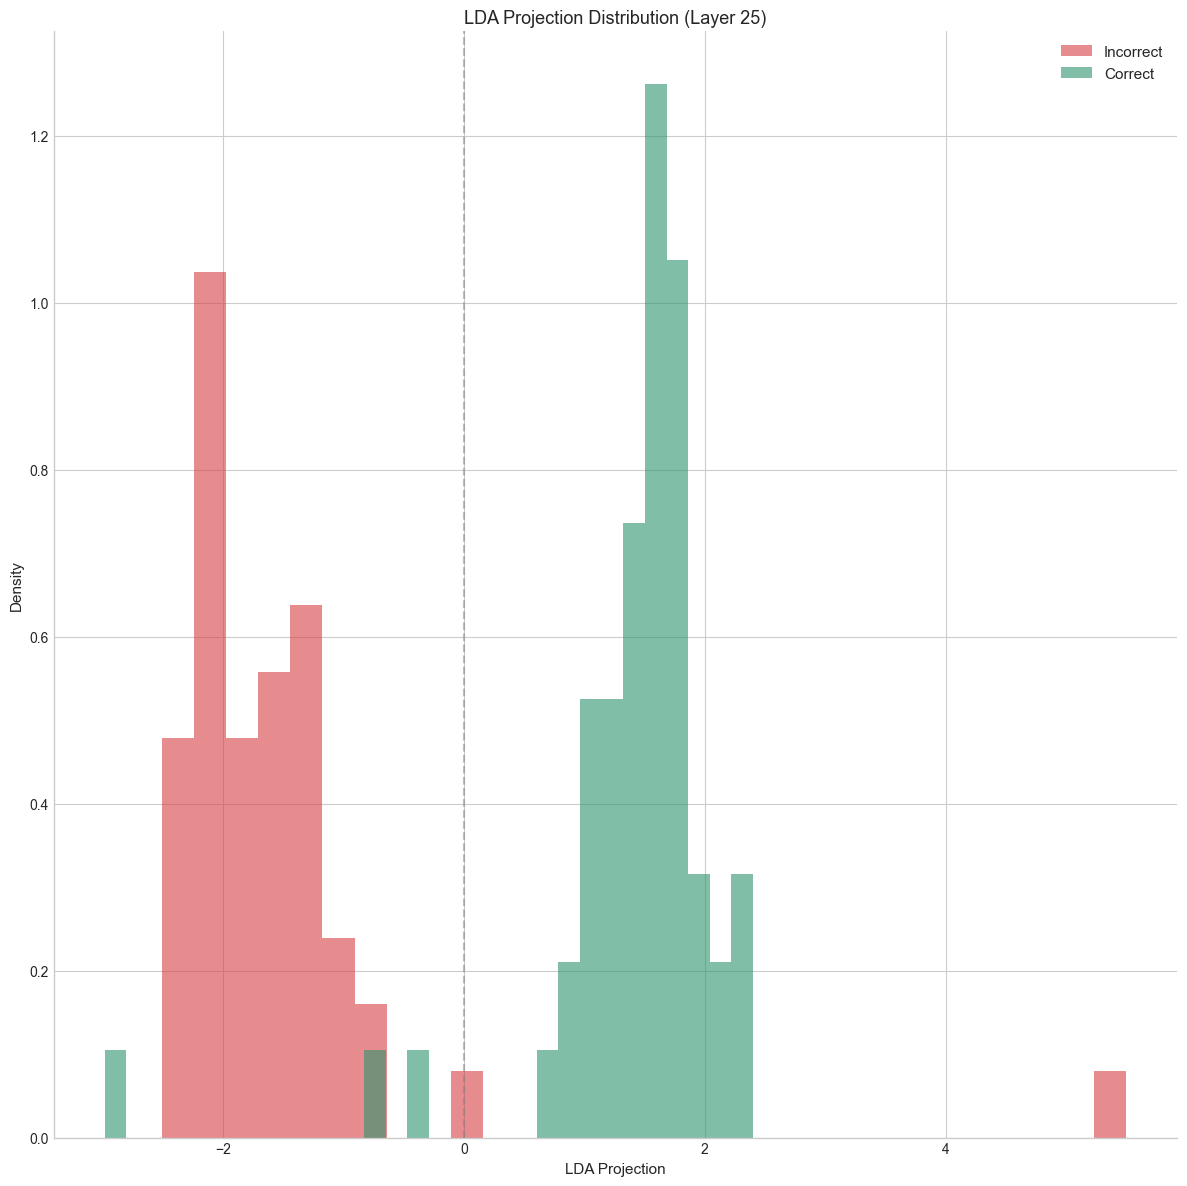

In [19]:
# Visualize LDA projection for best layer
fig, axes = plt.subplots(1, 1, figsize=(12, 12))

# LDA projection and histogram for layer 25
layer_25 = 25
if layer_25 in layers:
    pos_25 = np.where(layers == layer_25)[0][0]
    X_layer_25 = X[:, pos_25, :]
    lda_25 = LinearDiscriminantAnalysis(n_components=1)
    X_lda_25 = lda_25.fit_transform(X_layer_25, labels)
    
    ax = axes
    for label, color, name in [(0, COLORS['incorrect'], 'Incorrect'), (1, COLORS['correct'], 'Correct')]:
        mask = labels == label
        ax.hist(X_lda_25[mask].flatten(), bins=30, alpha=0.6, color=color, label=name, density=True)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set(xlabel='LDA Projection', ylabel='Density', title=f'LDA Projection Distribution (Layer 25)')
    ax.legend()
else:
    ax = axes
    ax.text(0.5, 0.5, 'Layer 25 not found in available layers!', 
            ha='center', va='center', fontsize=15)
    ax.axis('off')
# data_for_box = [X_lda[labels == 0].flatten(), X_lda[labels == 1].flatten()]
# bp = ax.boxplot(data_for_box, labels=['Incorrect', 'Correct'], patch_artist=True)
# bp['boxes'][0].set_facecolor(COLORS['incorrect'])
# bp['boxes'][1].set_facecolor(COLORS['correct'])
# ax.set(ylabel='LDA Projection', title=f'LDA Projection by Class (Layer {best_layer})')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lda_projection_best_layer.pdf')
plt.show()

## 2. LDA Separability Across All Layers

We compute LDA for each layer and measure how well each layer separates the classes.

In [5]:
# Compute LDA metrics for each layer
lda_results = []

for i, layer_idx in enumerate(layers):
    X_layer = X[:, i, :]
    
    # Fit LDA
    lda = LinearDiscriminantAnalysis(n_components=1)
    try:
        X_lda = lda.fit_transform(X_layer, labels)
        
        # Compute separation metrics
        proj_correct = X_lda[labels == 1].flatten()
        proj_incorrect = X_lda[labels == 0].flatten()
        
        # Fisher's criterion (between-class / within-class variance)
        mean_diff = np.abs(proj_correct.mean() - proj_incorrect.mean())
        pooled_std = np.sqrt((proj_correct.var() + proj_incorrect.var()) / 2)
        fisher_ratio = mean_diff / pooled_std if pooled_std > 0 else 0
        
        # Cross-validated accuracy
        cv_scores = cross_val_score(LinearDiscriminantAnalysis(), X_layer, labels, cv=5)
        
        lda_results.append({
            'layer_idx': layer_idx,
            'explained_var': lda.explained_variance_ratio_[0],
            'mean_diff': mean_diff,
            'fisher_ratio': fisher_ratio,
            'cv_accuracy': cv_scores.mean(),
            'cv_std': cv_scores.std()
        })
    except Exception as e:
        print(f'Layer {layer_idx}: LDA failed - {e}')

lda_df = pd.DataFrame(lda_results)
print(f'\nLDA analysis complete for {len(lda_df)} layers')
lda_df.head()


LDA analysis complete for 20 layers


,layer_idx,explained_var,mean_diff,fisher_ratio,cv_accuracy,cv_std
0,8,1.0,2.363672,2.365108,0.61,0.073485
1,9,1.0,2.887392,2.888547,0.59,0.080000
2,10,1.0,3.030221,3.032281,0.62,0.067823
3,11,1.0,3.068011,3.068114,0.64,0.101980
4,12,1.0,2.786819,2.789879,0.61,0.066332


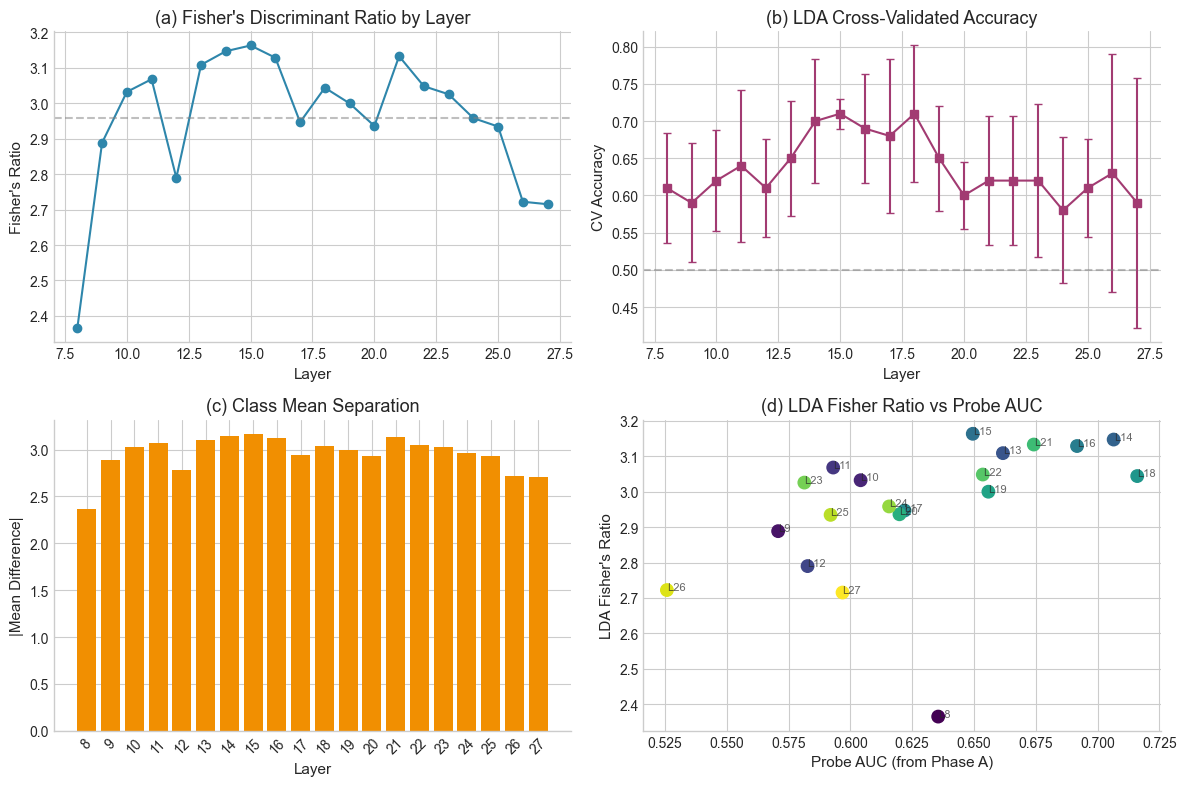

In [6]:
# Visualize LDA metrics across layers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Fisher's ratio by layer
ax = axes[0, 0]
ax.plot(lda_df['layer_idx'], lda_df['fisher_ratio'], 'o-', color=COLORS['primary'])
ax.set(xlabel='Layer', ylabel="Fisher's Ratio", title="(a) Fisher's Discriminant Ratio by Layer")
ax.axhline(lda_df['fisher_ratio'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')

# Cross-validated accuracy
ax = axes[0, 1]
ax.errorbar(lda_df['layer_idx'], lda_df['cv_accuracy'], yerr=lda_df['cv_std'], 
            fmt='s-', color=COLORS['secondary'], capsize=3)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set(xlabel='Layer', ylabel='CV Accuracy', title='(b) LDA Cross-Validated Accuracy')

# Mean difference
ax = axes[1, 0]
ax.bar(lda_df['layer_idx'].astype(str), lda_df['mean_diff'], color=COLORS['accent'])
ax.set(xlabel='Layer', ylabel='|Mean Difference|', title='(c) Class Mean Separation')
ax.tick_params(axis='x', rotation=45)

# Compare with original metrics (AUC)
ax = axes[1, 1]
merged = lda_df.merge(metrics_df[['layer_idx', 'auc']], on='layer_idx')
ax.scatter(merged['auc'], merged['fisher_ratio'], c=merged['layer_idx'], cmap='viridis', s=80)
ax.set(xlabel='Probe AUC (from Phase A)', ylabel="LDA Fisher's Ratio", 
       title='(d) LDA Fisher Ratio vs Probe AUC')
for _, r in merged.iterrows():
    ax.annotate(f'L{int(r["layer_idx"])}', (r['auc'], r['fisher_ratio']), fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lda_metrics_by_layer.pdf')
plt.show()

## 3. LDA vs PCA Comparison

Compare supervised (LDA) vs unsupervised (PCA) dimensionality reduction.

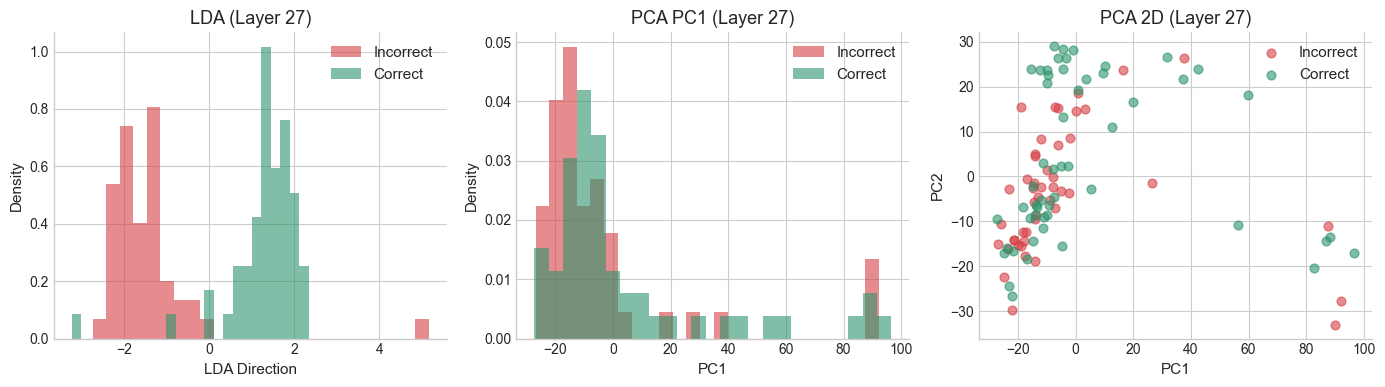


LDA direction explains 100.0% of between-class variance
PCA PC1 explains 24.2% of total variance
PCA PC2 explains 7.3% of total variance


In [7]:
# Compare LDA and PCA for best layer
layer_pos = np.where(layers == best_layer)[0][0]
X_layer = X[:, layer_pos, :]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_layer)

# LDA (1D projection)
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_scaled, labels)

# PCA (first component)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# LDA projection
ax = axes[0]
for label, color, name in [(0, COLORS['incorrect'], 'Incorrect'), (1, COLORS['correct'], 'Correct')]:
    mask = labels == label
    ax.hist(X_lda[mask].flatten(), bins=25, alpha=0.6, color=color, label=name, density=True)
ax.set(xlabel='LDA Direction', ylabel='Density', title=f'LDA (Layer {best_layer})')
ax.legend()

# PCA first component
ax = axes[1]
for label, color, name in [(0, COLORS['incorrect'], 'Incorrect'), (1, COLORS['correct'], 'Correct')]:
    mask = labels == label
    ax.hist(X_pca[mask, 0], bins=25, alpha=0.6, color=color, label=name, density=True)
ax.set(xlabel='PC1', ylabel='Density', title=f'PCA PC1 (Layer {best_layer})')
ax.legend()

# PCA 2D with class coloring
ax = axes[2]
for label, color, name in [(0, COLORS['incorrect'], 'Incorrect'), (1, COLORS['correct'], 'Correct')]:
    mask = labels == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, s=40, alpha=0.6, label=name)
ax.set(xlabel='PC1', ylabel='PC2', title=f'PCA 2D (Layer {best_layer})')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lda_vs_pca.pdf')
plt.show()

print(f'\nLDA direction explains {lda.explained_variance_ratio_[0]*100:.1f}% of between-class variance')
print(f'PCA PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of total variance')
print(f'PCA PC2 explains {pca.explained_variance_ratio_[1]*100:.1f}% of total variance')

## 4. LDA Direction Comparison with Learned U

Compare the LDA discriminant direction with the learned reasoning direction (U) from Phase A.

In [8]:
# Get learned direction for best layer
direction_keys = list(directions.keys())
def get_layer_num(key):
    s = str(key)
    return int(s.replace('L', '').replace('l', ''))

best_layer_key = None
for key in direction_keys:
    if get_layer_num(key) == best_layer:
        best_layer_key = key
        break

if best_layer_key:
    U_learned = directions[best_layer_key].flatten()
    U_lda = lda.coef_.flatten()
    
    # Normalize for comparison
    U_learned_norm = U_learned / np.linalg.norm(U_learned)
    U_lda_norm = U_lda / np.linalg.norm(U_lda)
    
    # Cosine similarity
    cos_sim = np.dot(U_learned_norm, U_lda_norm)
    print(f'Cosine similarity between learned U and LDA direction: {cos_sim:.4f}')
    print(f'Absolute cosine similarity: {abs(cos_sim):.4f}')
else:
    print(f'No learned direction found for layer {best_layer}')
    U_learned = None

Cosine similarity between learned U and LDA direction: 0.0973
Absolute cosine similarity: 0.0973


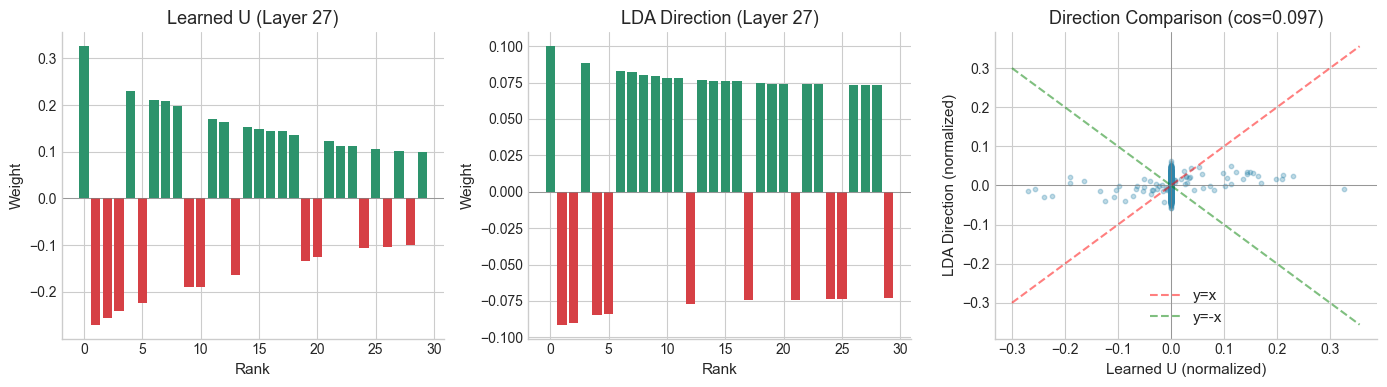

In [9]:
# Visualize direction comparison
if best_layer_key:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Top components of learned U
    ax = axes[0]
    top_k = 30
    sorted_idx_learned = np.argsort(np.abs(U_learned))[::-1][:top_k]
    colors = [COLORS['correct'] if U_learned[i] > 0 else COLORS['incorrect'] for i in sorted_idx_learned]
    ax.bar(range(top_k), U_learned[sorted_idx_learned], color=colors)
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.set(xlabel='Rank', ylabel='Weight', title=f'Learned U (Layer {best_layer})')
    
    # Top components of LDA direction
    ax = axes[1]
    sorted_idx_lda = np.argsort(np.abs(U_lda))[::-1][:top_k]
    colors = [COLORS['correct'] if U_lda[i] > 0 else COLORS['incorrect'] for i in sorted_idx_lda]
    ax.bar(range(top_k), U_lda[sorted_idx_lda], color=colors)
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.set(xlabel='Rank', ylabel='Weight', title=f'LDA Direction (Layer {best_layer})')
    
    # Scatter plot of component weights
    ax = axes[2]
    ax.scatter(U_learned_norm, U_lda_norm, alpha=0.3, s=10, c=COLORS['primary'])
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.axvline(0, color='gray', linewidth=0.5)
    # Add diagonal line
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'r--', alpha=0.5, label='y=x')
    ax.plot(lims, [-x for x in lims], 'g--', alpha=0.5, label='y=-x')
    ax.set(xlabel='Learned U (normalized)', ylabel='LDA Direction (normalized)', 
           title=f'Direction Comparison (cos={cos_sim:.3f})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'lda_vs_learned_direction.pdf')
    plt.show()

## 5. Multi-Layer LDA Visualization

Visualize LDA projections across multiple layers.

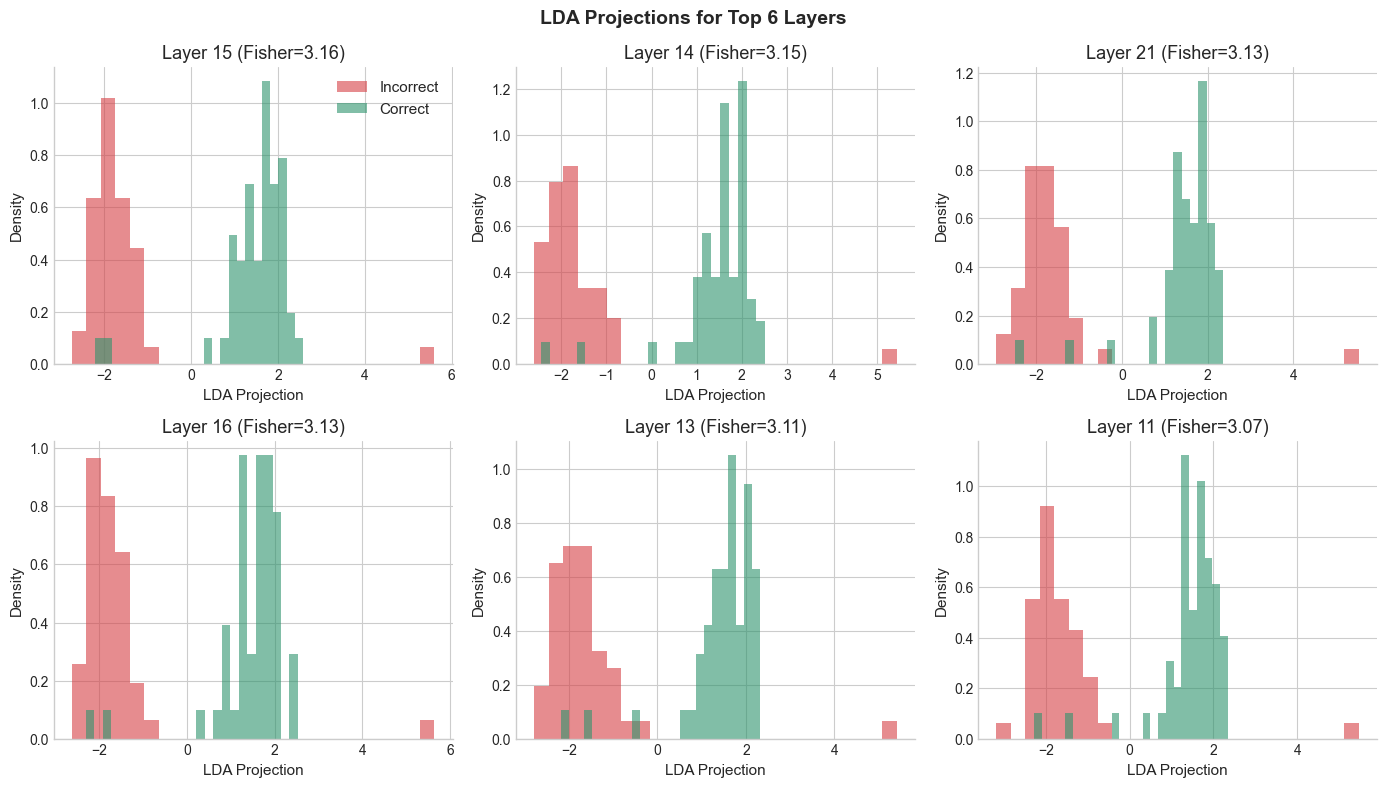

In [10]:
# Select top 6 layers by Fisher ratio
top_layers = lda_df.nlargest(6, 'fisher_ratio')['layer_idx'].values

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, layer_idx in enumerate(top_layers):
    layer_pos = np.where(layers == layer_idx)[0][0]
    X_layer = X[:, layer_pos, :]
    
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit_transform(X_layer, labels)
    
    ax = axes[i]
    for label, color, name in [(0, COLORS['incorrect'], 'Incorrect'), (1, COLORS['correct'], 'Correct')]:
        mask = labels == label
        ax.hist(X_lda[mask].flatten(), bins=25, alpha=0.6, color=color, label=name, density=True)
    
    fisher = lda_df[lda_df['layer_idx'] == layer_idx]['fisher_ratio'].values[0]
    ax.set_title(f'Layer {int(layer_idx)} (Fisher={fisher:.2f})')
    ax.set(xlabel='LDA Projection', ylabel='Density')
    if i == 0:
        ax.legend()

plt.suptitle('LDA Projections for Top 6 Layers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lda_multi_layer.pdf')
plt.show()

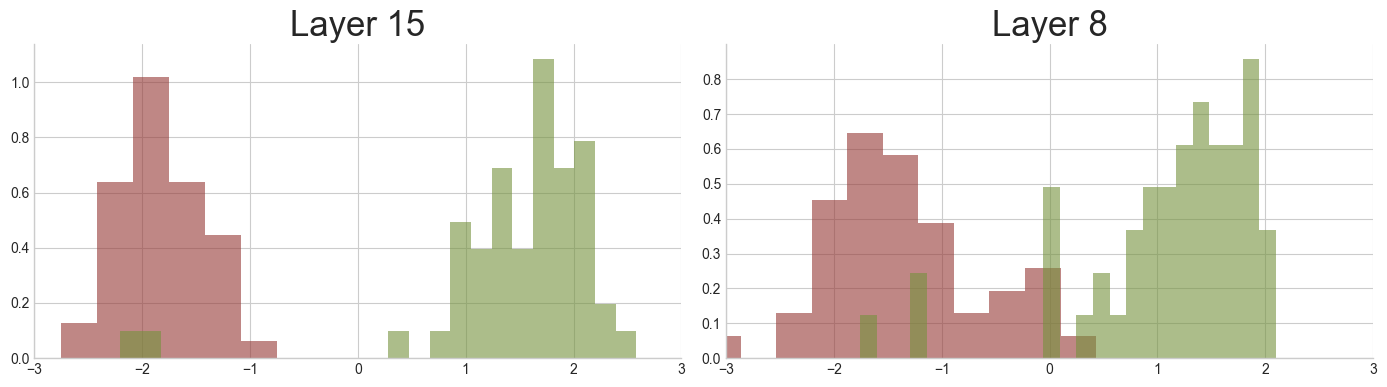

In [41]:
# Compare lowest and highest separability layers and plot their LDA projections

# Find layers with lowest and highest Fisher ratios (separability)
best_layer = lda_df.loc[lda_df['fisher_ratio'].idxmax(), 'layer_idx']
worst_layer = lda_df.loc[lda_df['fisher_ratio'].idxmin(), 'layer_idx']

# Extract data for both layers
best_pos = np.where(layers == best_layer)[0][0]
worst_pos = np.where(layers == worst_layer)[0][0]

X_best = X[:, best_pos, :]
X_worst = X[:, worst_pos, :]

lda_best = LinearDiscriminantAnalysis(n_components=1)
lda_worst = LinearDiscriminantAnalysis(n_components=1)

X_best_lda = lda_best.fit_transform(X_best, labels)
X_worst_lda = lda_worst.fit_transform(X_worst, labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Define the specific colors as requested
custom_incorrect = "#953834"
custom_correct = "#75923d"

for ax, (X_lda, layer_idx, fisher) in zip(
        axes, 
        [
            (X_best_lda, best_layer, lda_df[lda_df['layer_idx'] == best_layer]['fisher_ratio'].values[0]), 
             (X_worst_lda, worst_layer, lda_df[lda_df['layer_idx'] == worst_layer]['fisher_ratio'].values[0]),
        ]):
    for label, color, name in [
        (0, custom_incorrect, 'Incorrect'), 
        (1, custom_correct, 'Correct')
    ]:
        mask = labels == label
        ax.hist(X_lda[mask].flatten(), bins=25, alpha=0.6, color=color, label=name, density=True)
    # ax.set_xlabel('LDA Projection')
    # ax.set_ylabel('Density')
    layer_idx = '25' if layer_idx == '15' else layer_idx
    ax.set_title(f'Layer {int(layer_idx)}', fontsize = 25)
    ax.set_xlim(-3, 3)

    # ax.legend()

# plt.suptitle('LDA Projection: Highest vs Lowest Separability Layers', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lda_best_vs_worst_layer.pdf')
plt.show()


## 6. LDA Decision Boundary Visualization

Using PCA to reduce to 2D first, then showing LDA decision boundary.

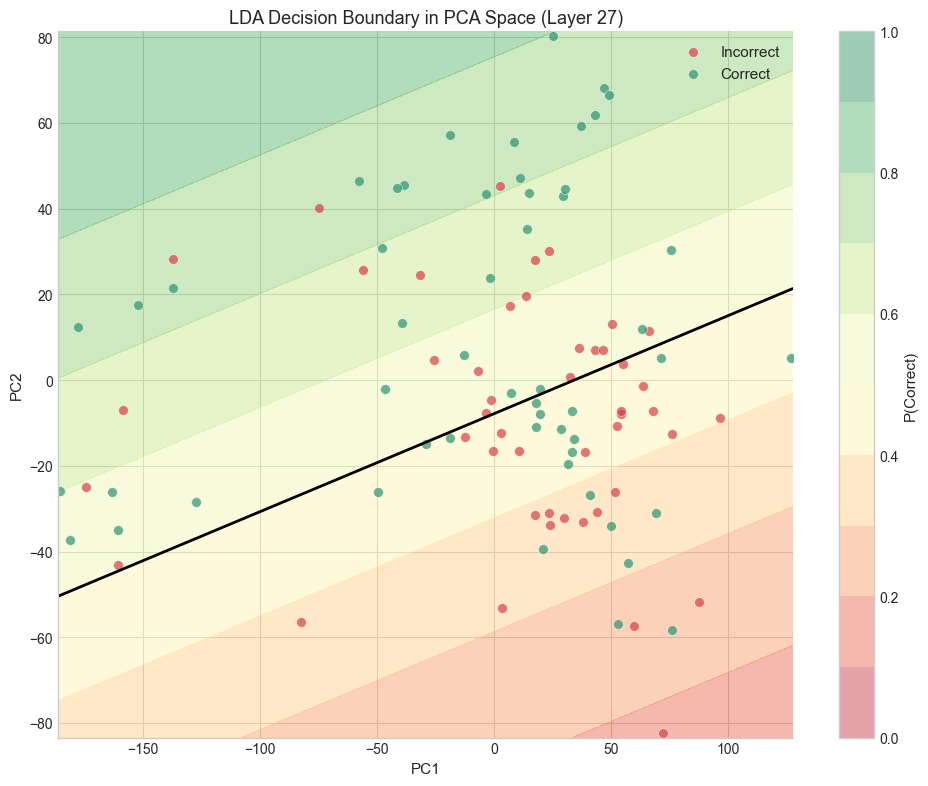

LDA accuracy in PCA 2D space: 0.580


In [11]:
# For best layer, reduce to 2D with PCA then fit LDA
layer_pos = np.where(layers == best_layer)[0][0]
X_layer = X[:, layer_pos, :]

# PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_layer)

# Fit LDA in 2D space
lda_2d = LinearDiscriminantAnalysis()
lda_2d.fit(X_pca, labels)

# Create mesh grid for decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on mesh
Z = lda_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot decision boundary
contour = ax.contourf(xx, yy, Z, levels=np.linspace(0, 1, 11), cmap='RdYlGn', alpha=0.4)
ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# Plot data points
for label, color, name in [(0, COLORS['incorrect'], 'Incorrect'), (1, COLORS['correct'], 'Correct')]:
    mask = labels == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, s=50, alpha=0.7, label=name, edgecolors='white', linewidth=0.5)

plt.colorbar(contour, ax=ax, label='P(Correct)')
ax.set(xlabel='PC1', ylabel='PC2', title=f'LDA Decision Boundary in PCA Space (Layer {best_layer})')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lda_decision_boundary.pdf')
plt.show()

print(f'LDA accuracy in PCA 2D space: {lda_2d.score(X_pca, labels):.3f}')

## 7. LDA Coefficient Heatmap Across Layers

Visualize how LDA coefficients vary across layers.

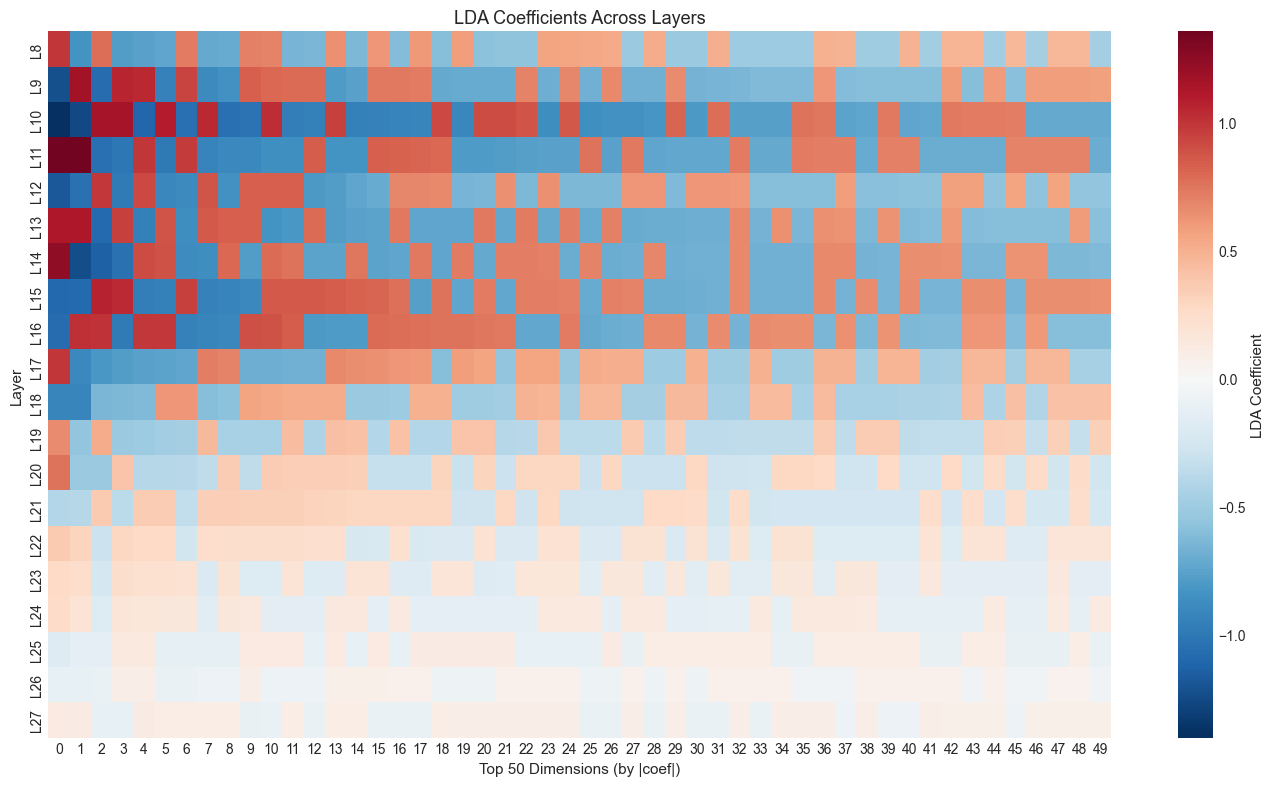

In [12]:
# Compute LDA coefficients for each layer
n_top_dims = 50  # Show top dimensions
coef_matrix = []
layer_labels = []

for i, layer_idx in enumerate(layers):
    X_layer = X[:, i, :]
    lda = LinearDiscriminantAnalysis(n_components=1)
    try:
        lda.fit(X_layer, labels)
        coefs = lda.coef_.flatten()
        # Get top dimensions by absolute value
        top_idx = np.argsort(np.abs(coefs))[::-1][:n_top_dims]
        coef_matrix.append(coefs[top_idx])
        layer_labels.append(f'L{int(layer_idx)}')
    except:
        pass

coef_matrix = np.array(coef_matrix)

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(coef_matrix, cmap='RdBu_r', center=0, 
            yticklabels=layer_labels, ax=ax,
            cbar_kws={'label': 'LDA Coefficient'})
ax.set(xlabel=f'Top {n_top_dims} Dimensions (by |coef|)', ylabel='Layer',
       title='LDA Coefficients Across Layers')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lda_coefficient_heatmap.pdf')
plt.show()

## 8. Summary Dashboard

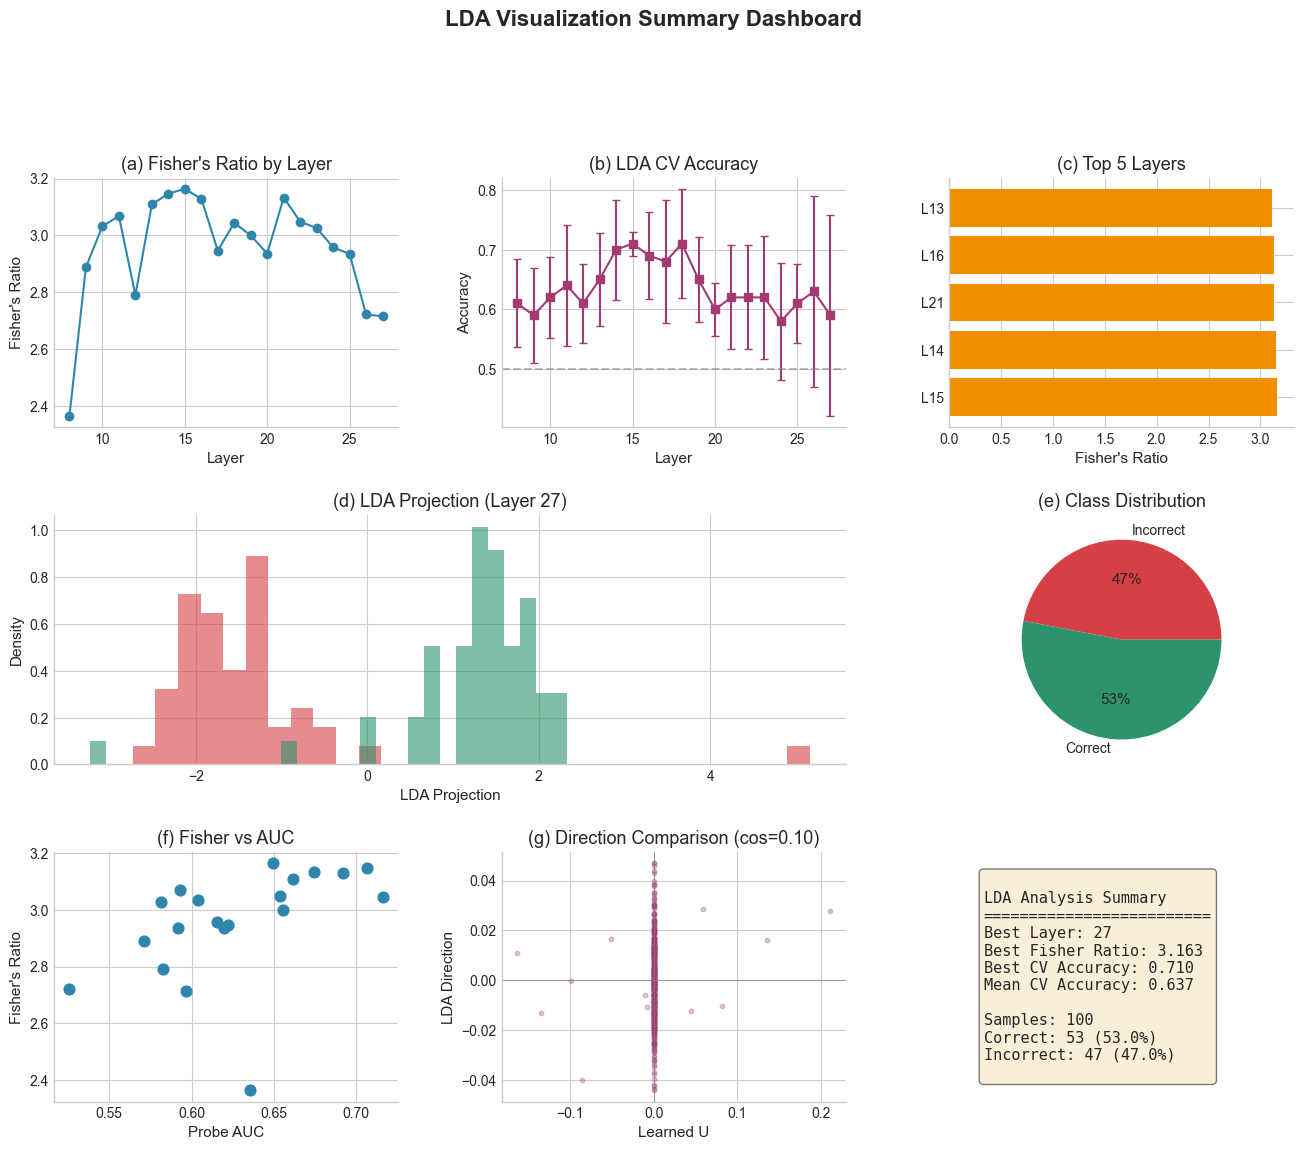


All figures saved to ../outputs/lda_analysis


In [13]:
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

# 1. Fisher ratio by layer
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(lda_df['layer_idx'], lda_df['fisher_ratio'], 'o-', color=COLORS['primary'])
ax1.set(xlabel='Layer', ylabel="Fisher's Ratio", title="(a) Fisher's Ratio by Layer")

# 2. CV Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(lda_df['layer_idx'], lda_df['cv_accuracy'], yerr=lda_df['cv_std'], 
             fmt='s-', color=COLORS['secondary'], capsize=3)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.set(xlabel='Layer', ylabel='Accuracy', title='(b) LDA CV Accuracy')

# 3. Top layers ranking
ax3 = fig.add_subplot(gs[0, 2])
top5 = lda_df.nlargest(5, 'fisher_ratio')
ax3.barh([f'L{int(l)}' for l in top5['layer_idx']], top5['fisher_ratio'], color=COLORS['accent'])
ax3.set(xlabel="Fisher's Ratio", title='(c) Top 5 Layers')

# 4. LDA projection for best layer
ax4 = fig.add_subplot(gs[1, 0:2])
layer_pos = np.where(layers == best_layer)[0][0]
lda_best = LinearDiscriminantAnalysis(n_components=1)
X_lda_best = lda_best.fit_transform(X[:, layer_pos, :], labels)
for label, color in [(0, COLORS['incorrect']), (1, COLORS['correct'])]:
    mask = labels == label
    ax4.hist(X_lda_best[mask].flatten(), bins=30, alpha=0.6, color=color, density=True)
ax4.set(xlabel='LDA Projection', ylabel='Density', title=f'(d) LDA Projection (Layer {best_layer})')

# 5. Class balance
ax5 = fig.add_subplot(gs[1, 2])
ax5.pie(np.bincount(labels.astype(int)), labels=['Incorrect', 'Correct'], 
        autopct='%1.0f%%', colors=[COLORS['incorrect'], COLORS['correct']])
ax5.set_title('(e) Class Distribution')

# 6. Fisher vs AUC
ax6 = fig.add_subplot(gs[2, 0])
merged = lda_df.merge(metrics_df[['layer_idx', 'auc']], on='layer_idx')
ax6.scatter(merged['auc'], merged['fisher_ratio'], c=COLORS['primary'], s=60)
ax6.set(xlabel='Probe AUC', ylabel="Fisher's Ratio", title='(f) Fisher vs AUC')

# 7. Direction similarity (if available)
ax7 = fig.add_subplot(gs[2, 1])
if best_layer_key:
    ax7.scatter(U_learned_norm[:500], U_lda_norm[:500], alpha=0.3, s=10, c=COLORS['secondary'])
    ax7.axhline(0, color='gray', linewidth=0.5)
    ax7.axvline(0, color='gray', linewidth=0.5)
    ax7.set(xlabel='Learned U', ylabel='LDA Direction', title=f'(g) Direction Comparison (cos={cos_sim:.2f})')
else:
    ax7.text(0.5, 0.5, 'No learned direction\navailable', ha='center', va='center', transform=ax7.transAxes)
    ax7.set_title('(g) Direction Comparison')

# 8. Summary statistics
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')
stats_text = f"""
LDA Analysis Summary
{'='*25}
Best Layer: {best_layer}
Best Fisher Ratio: {lda_df['fisher_ratio'].max():.3f}
Best CV Accuracy: {lda_df['cv_accuracy'].max():.3f}
Mean CV Accuracy: {lda_df['cv_accuracy'].mean():.3f}

Samples: {len(labels)}
Correct: {(labels==1).sum()} ({(labels==1).mean()*100:.1f}%)
Incorrect: {(labels==0).sum()} ({(labels==0).mean()*100:.1f}%)
"""
ax8.text(0.1, 0.5, stats_text, transform=ax8.transAxes, fontsize=11,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('LDA Visualization Summary Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.savefig(OUTPUT_DIR / 'lda_summary_dashboard.pdf', bbox_inches='tight')
plt.show()

print(f'\nAll figures saved to {OUTPUT_DIR}')

## Summary

In [14]:
print('='*60)
print('LDA VISUALIZATION SUMMARY')
print('='*60)

print('\nTop 5 Layers by Fisher Ratio:')
top5 = lda_df.nlargest(5, 'fisher_ratio')
for i, (_, r) in enumerate(top5.iterrows(), 1):
    print(f'  {i}. L{int(r["layer_idx"])}: Fisher={r["fisher_ratio"]:.3f}, CV Acc={r["cv_accuracy"]:.3f}')

print(f'\nOverall Statistics:')
print(f'  Mean Fisher Ratio: {lda_df["fisher_ratio"].mean():.3f}')
print(f'  Mean CV Accuracy: {lda_df["cv_accuracy"].mean():.3f}')
print(f'  Best Layer: {best_layer}')

if best_layer_key:
    print(f'\nDirection Comparison:')
    print(f'  Cosine similarity (Learned U vs LDA): {cos_sim:.4f}')
    print(f'  Interpretation: {"Highly aligned" if abs(cos_sim) > 0.8 else "Moderately aligned" if abs(cos_sim) > 0.5 else "Weakly aligned"}')

# Save results to CSV
lda_df.to_csv(OUTPUT_DIR / 'lda_metrics.csv', index=False)
print(f'\nResults saved to {OUTPUT_DIR / "lda_metrics.csv"}')

LDA VISUALIZATION SUMMARY

Top 5 Layers by Fisher Ratio:
  1. L15: Fisher=3.163, CV Acc=0.710
  2. L14: Fisher=3.147, CV Acc=0.700
  3. L21: Fisher=3.133, CV Acc=0.620
  4. L16: Fisher=3.129, CV Acc=0.690
  5. L13: Fisher=3.109, CV Acc=0.650

Overall Statistics:
  Mean Fisher Ratio: 2.958
  Mean CV Accuracy: 0.637
  Best Layer: 27

Direction Comparison:
  Cosine similarity (Learned U vs LDA): 0.0973
  Interpretation: Weakly aligned

Results saved to ../outputs/lda_analysis/lda_metrics.csv
